# Real Data Example

Finally, we test `bayes_cn_hfs` on some real data and demonstrate a general procedure for determining the carbon isotopic ratio from observations of CN and 13CN.

In [1]:
# General imports   
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

from bayes_cn_hfs import HFSModel

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.6.3+2.gfe5a862.dirty
bayes_cn_hfs version: 1.0.0-staging+0.g7b9ceed.dirty


## Load the data

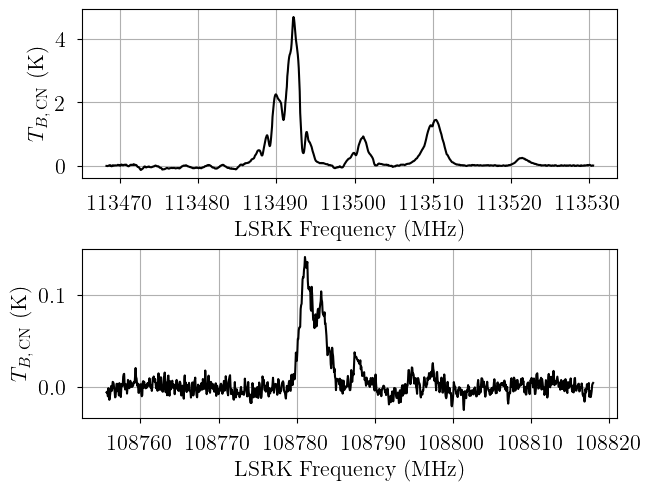

In [2]:
from bayes_spec import SpecData

data_12CN = np.genfromtxt("data_CN.tsv")
data_13CN = np.genfromtxt("data_13CN.tsv")

# estimate noise
noise_12CN = 1.4826 * np.median(np.abs(data_12CN[:, 0] - np.median(data_12CN[:, 0])))
noise_13CN = 1.4826 * np.median(np.abs(data_13CN[:, 0] - np.median(data_13CN[:, 0])))

obs_12CN = SpecData(
    1000.0 * data_12CN[:, 0],
    data_12CN[:, 1],
    noise_12CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,\rm CN}$ (K)",
)
obs_13CN = SpecData(
    1000.0 * data_13CN[:, 0],
    data_13CN[:, 1],
    noise_13CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,\rm CN}$ (K)",
)
data_12CN = {"observation": obs_12CN}
data = {"12CN": obs_12CN, "13CN": obs_13CN}

# Plot the data
fig, axes = plt.subplots(2, layout="constrained")
axes[0].plot(data["12CN"].spectral, data["12CN"].brightness, 'k-')
axes[1].plot(data["13CN"].spectral, data["13CN"].brightness, 'k-')
axes[0].set_xlabel(data["12CN"].xlabel)
axes[1].set_xlabel(data["13CN"].xlabel)
axes[0].set_ylabel(data["12CN"].ylabel)
_ = axes[1].set_ylabel(data["13CN"].ylabel)

## Determine Number of Clouds

The CN data has much greater signal-to-noise, so let's use those data to constrain the number of "cloud" components.

In [4]:
from bayes_cn_hfs import get_molecule_data

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)

In [7]:
from bayes_cn_hfs import HFSAnomalyModel
from bayes_spec import Optimize

max_n_clouds = 7
baseline_degree = 3
opt = Optimize(
    HFSAnomalyModel,
    data_12CN,
    mol_data=mol_data_12CN,
    max_n_clouds=max_n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True,
)
opt.add_priors(
    prior_log10_N = [14.0, 0.5], # mean and width of log10(N_u) prior (cm-2)
    prior_log10_tex = [1.0, 0.1], # mean and width of log10(T) prior (K)
    prior_fwhm = 2.0, # width of nonthermal FWHM prior (km/s)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_rms = 0.05, # width of spectral rms prior (K)
    prior_baseline_coeffs = [1.0, 1.0, 1.0, 0.5], # width of normalized polynomial baseline coeffs
    prior_tex_anomaly = 1.0, # width of the Tex anomaly prior (K)
    ordered = False, # do not assume optically-thin
)
opt.add_likelihood()

## Approximate with Variational Inference

Since VI is relatively fast, let's sample all of the models just to get an idea of how many "cloud" components we're dealing with. We will inspect the BICs for each model. If BIC continues to increase up to high `n_cloud`, then, due to the approximation nature of VI, we will be less confident in the accuracy of the reported BICs.

In [8]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.fit_all(**fit_kwargs)

Null hypothesis BIC = 8.363e+05
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 2900
Interrupted at 2,899 [2%]: Average Loss = 15,955


GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = -1.936e+02

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 8100
Interrupted at 8,099 [8%]: Average Loss = 5,094.5


GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = -1.214e+03

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 10500
Interrupted at 10,499 [10%]: Average Loss = 5,585.7


GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = -1.489e+03

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 7200
Interrupted at 7,199 [7%]: Average Loss = 5,398.8


GMM converged to unique solution
n_cloud = 4 solution = 0 BIC = -1.238e+03

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 9600
Interrupted at 9,599 [9%]: Average Loss = 4,592.1


GMM converged to unique solution
n_cloud = 5 solution = 0 BIC = -2.381e+03

Approximating n_cloud = 6 posterior...


Output()

Convergence achieved at 8700
Interrupted at 8,699 [8%]: Average Loss = 5,694.4


No solution found!
GMM found 0 unique solutions

Approximating n_cloud = 7 posterior...


Output()

Convergence achieved at 10900
Interrupted at 10,899 [10%]: Average Loss = 4,590.4


No solution found!
GMM found 0 unique solutions



In [15]:
n_clouds = np.arange(max_n_clouds + 1)
null_bic = opt.models[1].null_bic()
bics = np.array([null_bic] + [model.bic() for model in opt.models.values()])
for n_cloud, bic in zip(n_clouds, bics):
    print(n_cloud, bic)

No solutions. Try solve()
No solutions. Try solve()
0 836277.7419228945
1 -193.61496198024497
2 -1214.072731197971
3 -1488.5897467271875
4 -1238.0580328839885
5 -2381.097533373759
6 inf
7 inf


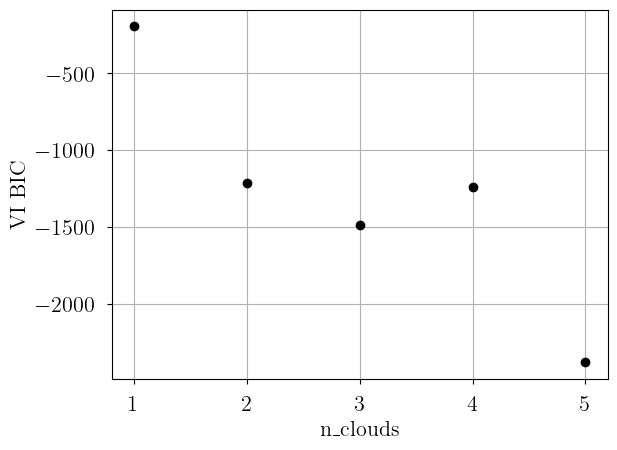

In [21]:
fig, ax = plt.subplots()
ax.plot(n_clouds[1:], bics[1:], 'ko')
ax.set_xlabel("n_clouds")
_ = ax.set_ylabel("VI BIC")

The models are improving up to `n_cloud = 5`, but then fail to converge. Let's sample each posterior with MCMC and judge how well the VI approximations are doing.

In [22]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(fit_kwargs=fit_kwargs, sample_kwargs=sample_kwargs, approx=False)

Null hypothesis BIC = 8.363e+05
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 2900
Interrupted at 2,899 [2%]: Average Loss = 15,955
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, log10_N_norm, log10_tex_norm, fwhm_norm, velocity_norm, rms_observation_norm, tex_anomaly_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 209 seconds.


GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = -1.954e+02

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 8100
Interrupted at 8,099 [8%]: Average Loss = 5,094.5
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, log10_N_norm, log10_tex_norm, fwhm_norm, velocity_norm, rms_observation_norm, tex_anomaly_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1949 seconds.


There were 9 divergences in converged chains.
GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = -1.225e+03

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 10500
Interrupted at 10,499 [10%]: Average Loss = 5,585.7
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, log10_N_norm, log10_tex_norm, fwhm_norm, velocity_norm, rms_observation_norm, tex_anomaly_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2327 seconds.


There were 5 divergences in converged chains.
GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = -1.525e+03

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 7200
Interrupted at 7,199 [7%]: Average Loss = 5,398.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, log10_N_norm, log10_tex_norm, fwhm_norm, velocity_norm, rms_observation_norm, tex_anomaly_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2826 seconds.


There were 9 divergences in converged chains.
GMM converged to unique solution
n_cloud = 4 solution = 0 BIC = -1.794e+03

Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 9600
Interrupted at 9,599 [9%]: Average Loss = 4,592.1
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, log10_N_norm, log10_tex_norm, fwhm_norm, velocity_norm, rms_observation_norm, tex_anomaly_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10875 seconds.


There were 39 divergences in converged chains.
GMM converged to unique solution
n_cloud = 5 solution = 0 BIC = -2.854e+03

Sampling n_cloud = 6 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 8700
Interrupted at 8,699 [8%]: Average Loss = 5,694.4
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, log10_N_norm, log10_tex_norm, fwhm_norm, velocity_norm, rms_observation_norm, tex_anomaly_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22916 seconds.


Only 3 chains appear converged.
There were 7 divergences in converged chains.
GMM converged to unique solution
n_cloud = 6 solution = 0 BIC = -2.873e+03

Sampling n_cloud = 7 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 10900
Interrupted at 10,899 [10%]: Average Loss = 4,590.4
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, log10_N_norm, log10_tex_norm, fwhm_norm, velocity_norm, rms_observation_norm, tex_anomaly_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16300 seconds.


There were 9 divergences in converged chains.
GMM converged to unique solution
n_cloud = 7 solution = 0 BIC = -2.251e+03



In [24]:
null_bic_mcmc = opt.models[1].null_bic()
bics_mcmc = np.array([null_bic_mcmc] + [model.bic() for model in opt.models.values()])
for n_cloud, bic in zip(n_clouds, bics_mcmc):
    print(n_cloud, bic)

0 836277.7419228945
1 -195.41331933509832
2 -1225.3054292090476
3 -1525.1787753105948
4 -1793.749390706615
5 -2854.2843057200357
6 -2873.374148364298
7 -2251.248615717182


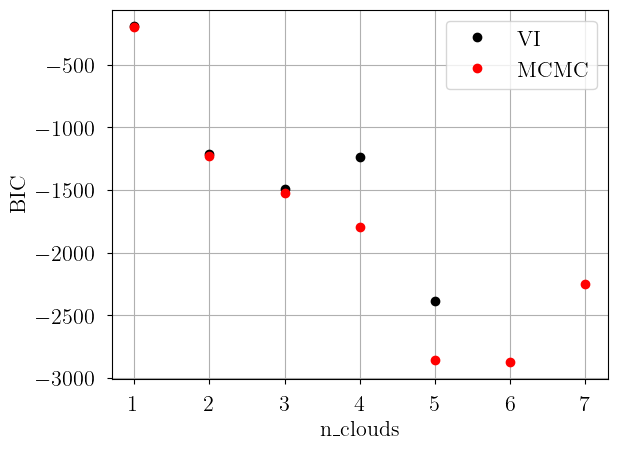

In [25]:
fig, ax = plt.subplots()
ax.plot(n_clouds[1:], bics[1:], 'ko', label="VI")
ax.plot(n_clouds[1:], bics_mcmc[1:], 'ro', label="MCMC")
ax.set_xlabel("n_clouds")
ax.legend(loc="best")
_ = ax.set_ylabel("BIC")

Sampling: [observation]


Output()

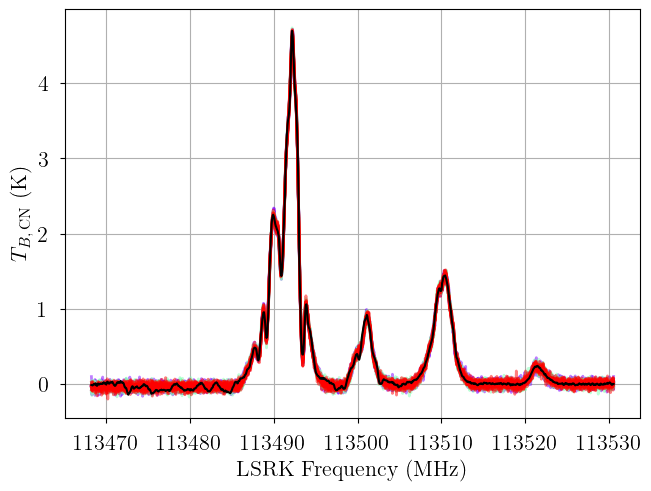

In [26]:
from bayes_spec.plots import plot_predictive

posterior = opt.best_model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(opt.best_model.data, posterior.posterior_predictive)

Let's also inspect the residuals.

Text(0, 0.5, '$T_{B,\\,\\rm CN}$ (K)')

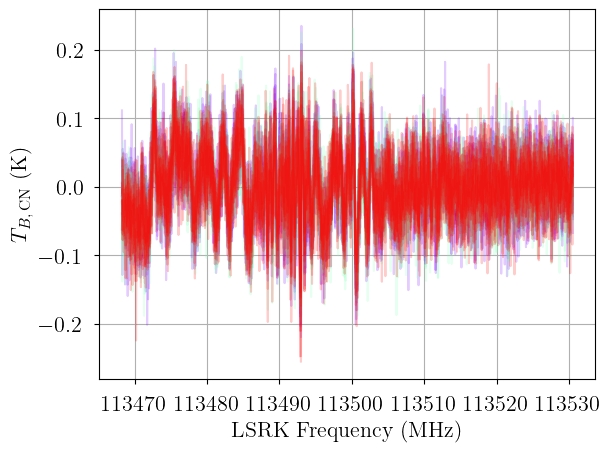

In [27]:
# Plot the residuals
fig, ax = plt.subplots()

color = iter(plt.cm.rainbow(np.linspace(0, 1, len(posterior.posterior_predictive.chain))))
for chain in posterior.posterior_predictive.chain:
    c = next(color)
    ax.plot(
        data["12CN"].spectral,
        posterior.posterior_predictive["observation"].sel(
            chain=chain, draw=slice(None, None, 1)
        ).T - data["12CN"].brightness[:, None],
        "-",
        color=c,
        alpha=0.2,
    )
ax.set_xlabel(data["12CN"].xlabel)
ax.set_ylabel(data["12CN"].ylabel)

In [28]:
pm.summary(opt.best_model.trace.solution_0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_observation_norm[0],-0.434,0.004,-0.442,-0.427,0.000,0.000,2567.0,2379.0,1.00
baseline_observation_norm[1],0.107,0.011,0.087,0.128,0.000,0.000,2588.0,2325.0,1.00
baseline_observation_norm[2],0.102,0.065,-0.021,0.219,0.001,0.001,2741.0,2304.0,1.00
baseline_observation_norm[3],-1.916,0.433,-2.708,-1.073,0.009,0.006,2505.0,2262.0,1.00
fwhm[0],3.203,0.103,2.991,3.374,0.003,0.002,1568.0,1828.0,1.00
fwhm[1],2.058,0.042,1.983,2.142,0.001,0.001,1093.0,1689.0,1.00
fwhm[2],1.857,0.070,1.734,1.993,0.001,0.001,2424.0,2380.0,1.00
fwhm[3],1.701,0.059,1.586,1.807,0.002,0.001,1169.0,1955.0,1.00
fwhm[4],6.888,0.146,6.631,7.171,0.003,0.002,2597.0,2249.0,1.00
fwhm[5],3.494,0.163,3.188,3.799,0.004,0.003,1967.0,1842.0,1.00


## Model Definition

In [33]:
from bayes_cn_hfs import CNRatioAnomalyModel

# Initialize and define the model
n_clouds = 6
baseline_degree = 3
model = CNRatioAnomalyModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [14.0, 0.5], # mean and width of log10(12CN N) prior (cm-2)
    prior_log10_tex = [1.0, 0.1], # mean and width of log10(T) prior (K)
    prior_fwhm = 2.0, # width of nonthermal FWHM prior (km/s)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_ratio_13C_12C = 0.01, # width of the 13C/12C prior
    prior_rms_12CN = 0.05, # width of the 12CN spectral rms prior (K)
    prior_rms_13CN = 0.05, # width of the 13CN spectral rms prior (K)
    prior_baseline_coeffs = {
        "12CN": [1.0, 1.0, 1.0, 0.5], # width of polynomial baseline coefficients prior
        "13CN": [1.0, 1.0, 1.0, 0.5],
    },
    prior_tex_12CN_anomaly = 1.0, # width of the 12CN Tex anomaly prior (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

## Variational Inference

In [34]:
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)

Output()

Convergence achieved at 8100
Interrupted at 8,099 [8%]: Average Loss = 3,637.8


In [35]:
# posterior samples stored in model.trace.posterior
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_12CN_norm[0],-0.432,0.003,-0.438,-0.425,0.000,0.000,913.0,908.0,NaN
baseline_12CN_norm[1],0.061,0.011,0.042,0.083,0.000,0.000,1147.0,842.0,NaN
baseline_12CN_norm[2],0.013,0.065,-0.118,0.123,0.002,0.002,945.0,899.0,NaN
baseline_12CN_norm[3],-0.582,0.428,-1.410,0.178,0.014,0.010,876.0,905.0,NaN
baseline_13CN_norm[0],-0.511,0.010,-0.531,-0.494,0.000,0.000,1080.0,904.0,NaN
baseline_13CN_norm[1],-0.103,0.034,-0.168,-0.039,0.001,0.001,1204.0,890.0,NaN
baseline_13CN_norm[2],3.145,0.204,2.746,3.500,0.007,0.005,958.0,942.0,NaN
baseline_13CN_norm[3],0.370,0.561,-0.570,1.491,0.018,0.013,998.0,916.0,NaN
fwhm[0],2.223,0.027,2.175,2.273,0.001,0.001,985.0,931.0,NaN
fwhm[1],3.137,0.022,3.099,3.178,0.001,0.000,990.0,941.0,NaN


Sampling: [12CN, 13CN]


Output()

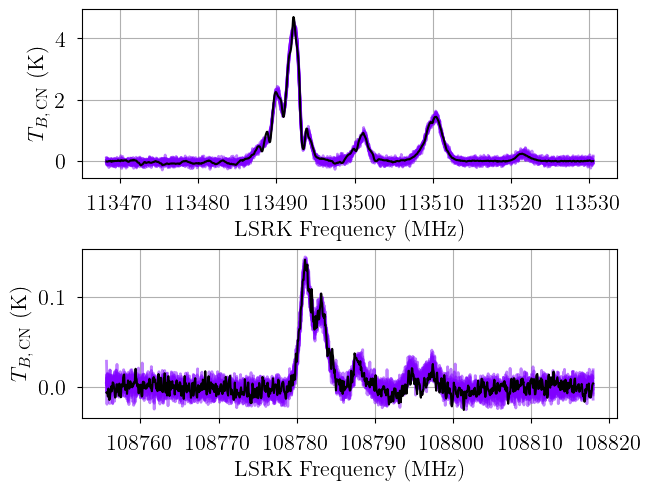

In [37]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## MCMC

In [38]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 8100
Interrupted at 8,099 [8%]: Average Loss = 3,637.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_12CN_norm, baseline_13CN_norm, log10_N_12CN_norm, log10_tex_norm, fwhm_norm, velocity_norm, ratio_13C_12C_norm, rms_12CN_norm, rms_13CN_norm, tex_12CN_anomaly_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42746 seconds.


There were 16 divergences in converged chains.
Runtime: 718.42 minutes


In [42]:
model.solve(p_threshold=0.99)

GMM found 2 unique solutions
Solution 0: chains [1]
Solution 1: chains [2, 3]


In [45]:
pm.summary(model.trace.solution_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_12CN_norm[0],-0.459,0.011,-0.479,-0.439,0.001,0.001,127.0,610.0,1.01
baseline_12CN_norm[1],0.084,0.013,0.058,0.107,0.000,0.000,1792.0,1483.0,1.00
baseline_12CN_norm[2],0.448,0.145,0.175,0.705,0.012,0.009,146.0,669.0,1.01
baseline_12CN_norm[3],-1.076,0.468,-1.903,-0.146,0.011,0.008,1917.0,1448.0,1.00
baseline_13CN_norm[0],-0.528,0.018,-0.563,-0.496,0.001,0.000,844.0,1160.0,1.00
baseline_13CN_norm[1],-0.102,0.033,-0.166,-0.042,0.001,0.001,2215.0,1290.0,1.00
baseline_13CN_norm[2],3.334,0.295,2.793,3.897,0.009,0.007,994.0,1319.0,1.00
baseline_13CN_norm[3],0.330,0.490,-0.561,1.218,0.010,0.009,2356.0,1409.0,1.00
fwhm[0],2.426,0.032,2.368,2.488,0.002,0.002,239.0,248.0,1.00
fwhm[1],1.787,0.034,1.725,1.852,0.001,0.001,1029.0,1199.0,1.00


Sampling: [12CN, 13CN]


Output()

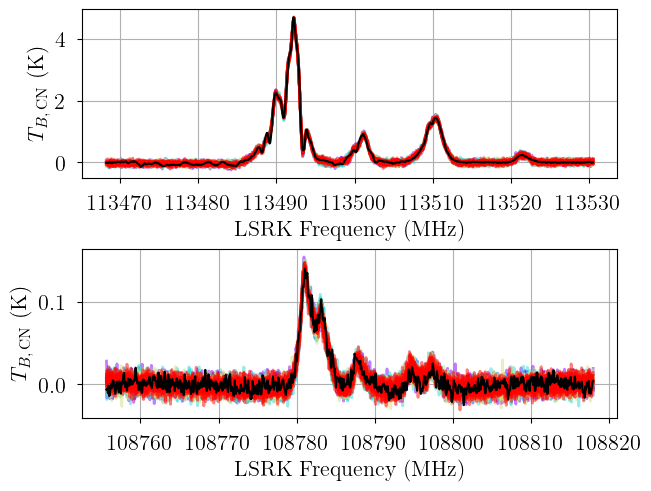

In [40]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

Note that there are two solutions, and one chain did not converge. These results are dubious. More chains are needed, and better tuning of the MCMC hyperparameters. 